In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
# tf.config.list_physical_devices()

sys.path.append( '..' )
from utils import LP_PSDs, plot_labels, plot_some_LP, data_preprocesados

 instala AntroPy [https://raphaelvallat.com/antropy] pip3 install antropy


Hasta ahora hemos visto que la combinación TSNE+GMM nos da unos resultados que permite entrenar un clasificador con muy buena precision.
Sin embargo, no hemos discutido sobre la extracción de parametros que, de alguna forma, es la base de nuestros resultados.

EL objetivo de este cuaderno es aplicar Redes Nauronales, y en particular AutoEncoders, para la extracción de parametros que permita mejorar la selección de clusters en el TSNE+GMM. 

Vamos a trabajar en el dominio espectral de la señal. Así que aplicaremos una nfft que permita describir el contenido espectral de todas las señales con el mismo tamaño. De esta forma, cada señal vendra parametrizada por su PSD que tiene un tamaño dado por la fq_size. 

In [2]:
x_all, (x_train, x_test) = LP_PSDs(test_size=0.5)
fq_size = x_train.shape[1]

X_all = x_all.reshape(x_all.shape[0], fq_size, 1)
X_test = x_test.reshape(x_test.shape[0], fq_size, 1)
X_train =x_train.reshape(x_train.shape[0], fq_size, 1)

## 1. Simple AutoEncoder

In [3]:
keras.backend.clear_session()
input_img = keras.layers.Input(shape=(fq_size,))
encoded = keras.layers.Dense(5, activation='relu')(input_img)
decoded = keras.layers.Dense(fq_size, activation='sigmoid')(encoded)
AE = keras.models.Model(input_img, decoded)
keras.utils.plot_model(AE, show_shapes=True)
AE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 97)]              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 490       
_________________________________________________________________
dense_1 (Dense)              (None, 97)                582       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________


In [4]:
AE.compile(optimizer='adam', loss='binary_crossentropy')
history = AE.fit(x_train, x_train,
                epochs=200,
                batch_size=40,
                shuffle=True,
                validation_data=(x_test, x_test)
                )

Epoch 1/200
14/14 [==============================] - 1s 12ms/step - loss: 0.6897 - val_loss: 0.6841
Epoch 2/200
14/14 [==============================] - 0s 2ms/step - loss: 0.6784 - val_loss: 0.6701
Epoch 3/200
14/14 [==============================] - 0s 2ms/step - loss: 0.6614 - val_loss: 0.6488
Epoch 4/200
14/14 [==============================] - 0s 2ms/step - loss: 0.6365 - val_loss: 0.6199
Epoch 5/200
14/14 [==============================] - 0s 2ms/step - loss: 0.6042 - val_loss: 0.5832
Epoch 6/200
14/14 [==============================] - 0s 2ms/step - loss: 0.5637 - val_loss: 0.5393
Epoch 7/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5183 - val_loss: 0.4952
Epoch 8/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4763 - val_loss: 0.4592
Epoch 9/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4439 - val_loss: 0.4335
Epoch 10/200
14/14 [==============================] - 0s 2ms/step - loss: 0.4209 - val_loss: 0.4154
Epoch 11

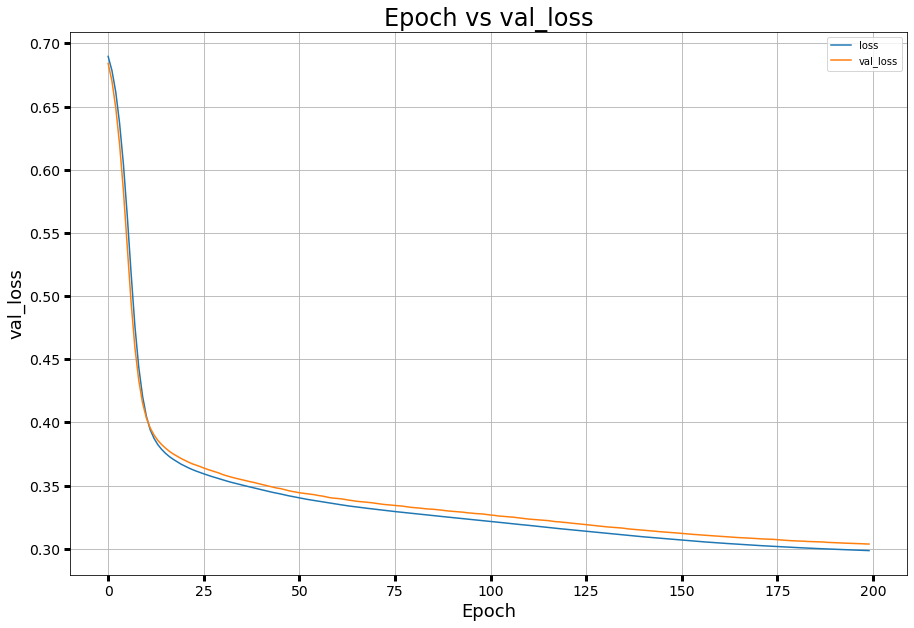

In [5]:
df = pd.DataFrame(history.history)
df.plot(figsize=(15,10))
plt.title('Epoch vs val_loss', fontsize= 24)
plt.xlabel('Epoch', fontsize= 18)
plt.ylabel('val_loss', fontsize= 18)
plt.tick_params(axis='both', which='major', labelsize=14, length=6, width=3)
plt.savefig('img/SAE_training.png', bbox_inches = 'tight')
plt.grid(True)
plt.show()

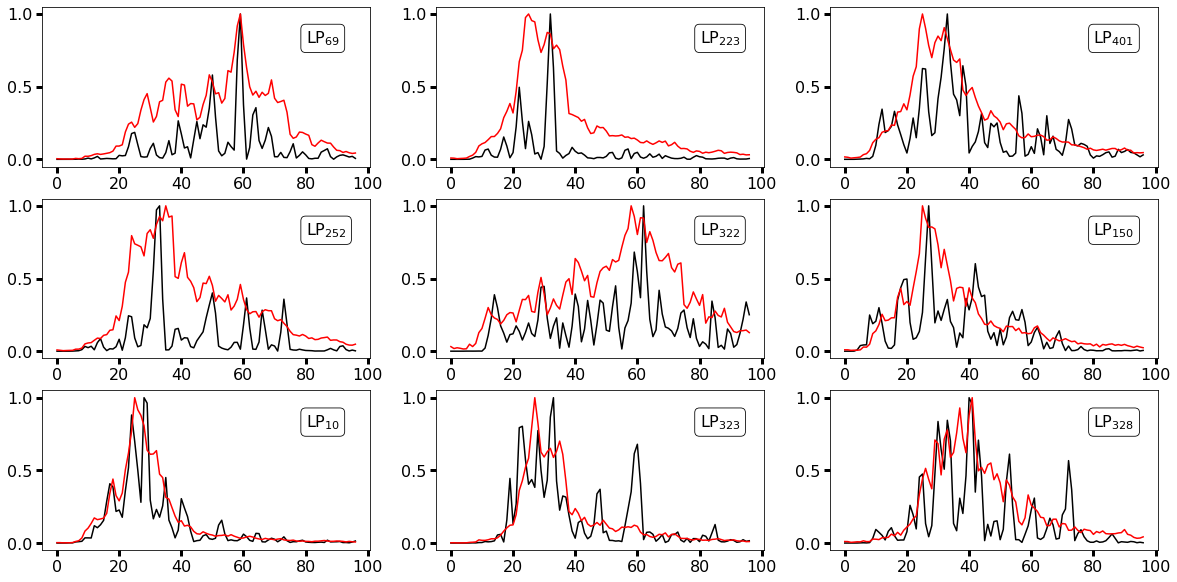

In [6]:
x_pred = AE.predict(x_test)
x_index = np.arange(x_test.shape[0])
x_some = x_index[np.random.choice(x_test.shape[0], 9, replace=False)]

plt.figure(figsize=(20, 10))
for i, n in enumerate(x_some):
    ax = plt.subplot(3, 3, i + 1)
    ax.plot(x_test[n,:], color='k')
    ax.plot(x_pred[n,:]/x_pred[n,:].max(), color='r')
    ax.annotate(r'LP$_{%i}$' % n, (80, 0.8), bbox=dict(boxstyle="round", fc='w', ec="k", lw=0.8), size=16)
    ax.tick_params(axis='both', which='major', labelsize=16, length=6, width=3)
plt.savefig('img/SAE_predict.png', bbox_inches = 'tight')
plt.show()
plt.close()

In [7]:
encoder = keras.models.Model(input_img, encoded)
x_encoder = encoder.predict(x_all)
x_encoder.shape

(1044, 5)

## 2. Evaluación de los nuevos parametros

In [8]:
ss = StandardScaler()
X_ec = ss.fit_transform(x_encoder)

In [9]:
tsne = TSNE(init="pca")
X_valid_2D = tsne.fit_transform(X_ec)
gmm = GaussianMixture(n_components=7, n_init=10, random_state=5).fit(X_valid_2D)
y_predict = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)

labels = list(Counter(y_predict).keys())

print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')
print('\n', Counter(y_predict))

C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


 Akaike information criterion (AIC):  17597
 Bayesian information criterion (BIC):  17800

 Counter({3: 200, 1: 182, 0: 171, 4: 138, 5: 125, 2: 115, 6: 113})


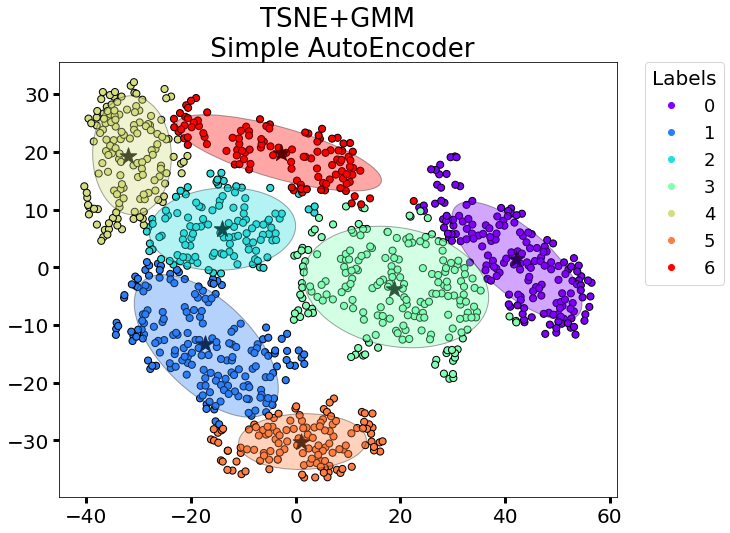

In [10]:
plot_labels(X_valid_2D, y_predict, cmap='rainbow', title='TSNE+GMM\n Simple AutoEncoder', show_centroid=True ,ellipse=(gmm.means_, gmm.covariances_))
plt.savefig('img/SAE_graph.png', bbox_inches = 'tight')
plt.show()
plt.close()

In [11]:
y, y_best = np.where(prob>0.99)
y_best_label = list(Counter(y_best).keys())
y_best_label.sort()

print(f'Total: {len(y)}') 
print('Label, nro_LPs')
print('---------------')
for n in y_best_label:
    i = Counter(y_best)[n]
    print(f'{n:^5}', f'{i:^7}')

Total: 176
Label, nro_LPs
---------------
  1     72   
  3     86   
  4      7   
  6     11   


En resumen, si bien estos nuevos parametros son capaces de reproducir el espectro de las señales mediante un decoder específico, no notamos ninguna mejora al aplicar el procedimiento TSNE+GMM. 

Por un lado, las métricas AIC y BIC muestran valores mayores al procedimiento original. Por otro, el numero de señales con una probabilidad de pertenencia a clases mayor al 99% es considerablemente menor.

3 [ 606  983 1016]


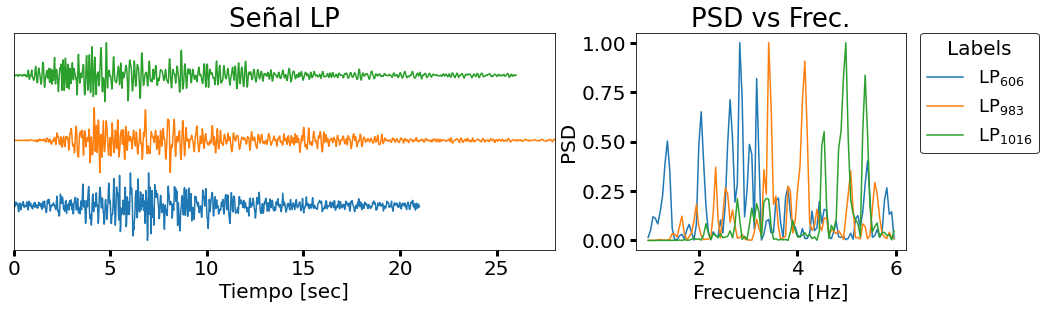

In [12]:
plot_some_LP(y_best, 3, rand_int=3, y_index=y)
plt.savefig('img/SAE_LP1.png', bbox_inches = 'tight')
plt.show()
plt.close()

## 3. Combinación de parametros

Dado que explotar la parametrización de las señales mediante autoencoders no ha dado un resultado mejor que en el procesamiento anterior. La idea es combinar la información para obtener una base de datos más completa. En particular vamos a tener 15 parametros más, es decir, 31 parametros por señal.

In [13]:
X_raw = data_preprocesados()
X_all = np.hstack((X_raw, X_ec))
print(X_all.shape)

(1044, 21)


In [14]:
tsne = TSNE(init='pca')
X_all_2D = tsne.fit_transform(X_all)

gmm = GaussianMixture(n_components=7, n_init=10).fit(X_all_2D)
y_predict = gmm.predict(X_all_2D)
prob = gmm.predict_proba(X_all_2D)

labels = list(Counter(y_predict).keys())

print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_all_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_all_2D):.0f}')
print('\n', Counter(y_predict))

C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


 Akaike information criterion (AIC):  17521
 Bayesian information criterion (BIC):  17724

 Counter({4: 232, 1: 159, 3: 152, 5: 138, 2: 131, 6: 120, 0: 112})


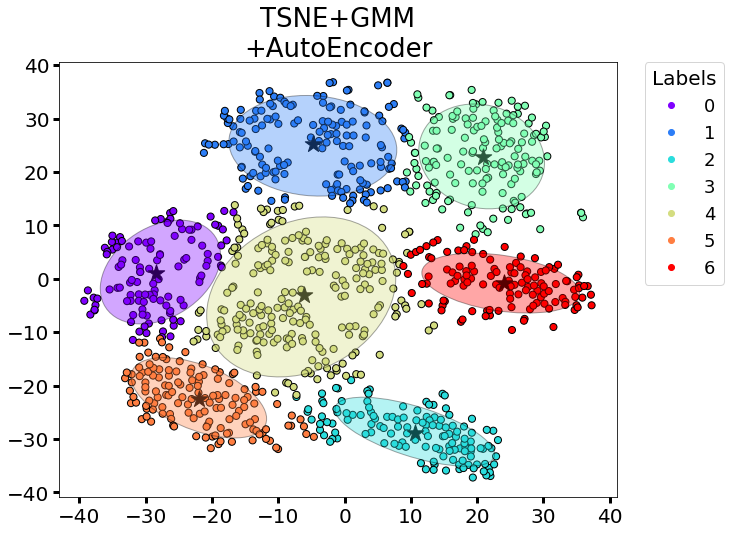

In [15]:
plot_labels(X_all_2D, y_predict, cmap='rainbow', title='TSNE+GMM\n+AutoEncoder', show_centroid=True ,ellipse=(gmm.means_, gmm.covariances_))
plt.savefig('img/SAE_params_comb.png', bbox_inches = 'tight')
plt.show()
plt.close()

6 [579 668 583]


C:\Users\Pablo\anaconda3\envs\tf\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 1024 is greater than input length  = 800, using nperseg = 800
  warnings.warn('nperseg = {0:d} is greater than input length '


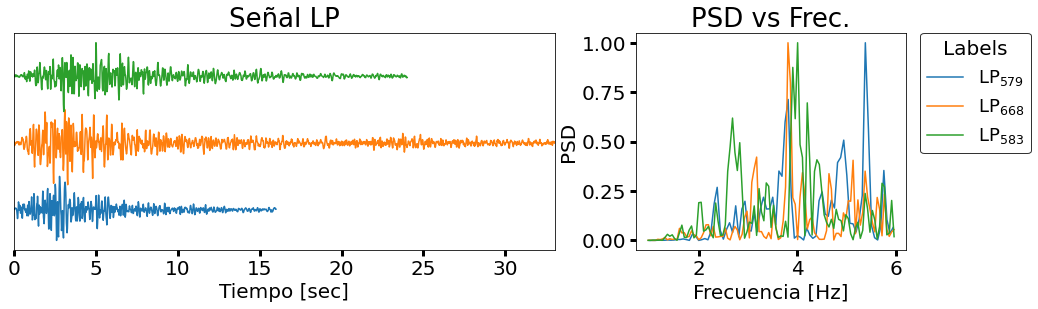

In [18]:
plot_some_LP(y_predict, 6, rand_int=3)
plt.savefig('img/SAE_params_comb_LP1.png', bbox_inches = 'tight')
plt.show()
plt.close()